In [9]:
import full_model
import fast_model
import fast_model_improved
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed
import pickle

## Load the model

In [10]:
# Load the graph from the file
save_path = '/Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/facebook.gpickle'
try:
    with open(save_path, 'rb') as f:
        G_fb = pickle.load(f)
    print(f"Graph loaded from {save_path}")
except Exception as e:
    print(f"An error occurred while loading the graph: {e}")

# Display basic information about the graph
print(f"Number of nodes: {G_fb.number_of_nodes()}")
print(f"Number of edges: {G_fb.number_of_edges()}")
print(f"Average degree: {sum(dict(G_fb.degree()).values()) / G_fb.number_of_nodes():.2f}")

# Perform additional operations on the graph
# Example: Print the neighbors of node 0
if 0 in G_fb:
    print(f"Neighbors of node 0: {list(G_fb.neighbors(0))}")
else:
    print("Node 0 is not in the graph")

Graph loaded from /Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/facebook.gpickle
Number of nodes: 4039
Number of edges: 88234
Average degree: 43.69
Neighbors of node 0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 18

In [11]:
# def generate_and_find_inf(steps, num_influencers=0):

#     model_inf = fast_model_improved.InfluenceDeinfluenceModel(G_fb)
#     model_inf.set_initial_states()
#     initial_influencers = model_inf.greedy_hill_climbing(num_influencers, steps)

#     #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
#     print("Optimized Initial Influencers:", initial_influencers)

#     return model_inf, initial_influencers

In [12]:
def generate_and_find_inf(steps, num_influencers=10):

    model = fast_model_improved.InfluenceDeinfluenceModel(G_fb)
    model.selected_influencers = model.random_influencers(num_influencers)

    #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
    print("Initial Influencers:", model.selected_influencers)

    return model, model.selected_influencers

In [13]:
inf_steps = 2
num_influencers = 50

results = generate_and_find_inf(inf_steps, num_influencers=num_influencers)

(model, optimized_influencers) = results

Initial Influencers: {2055, 398, 3985, 3603, 1172, 1046, 2710, 2584, 3740, 2461, 1564, 286, 32, 1185, 801, 163, 2597, 2474, 2859, 3627, 43, 3246, 301, 2480, 3121, 2358, 3127, 1471, 2753, 1346, 4034, 2114, 69, 3015, 2762, 2507, 3916, 593, 3796, 3799, 3672, 996, 3047, 1515, 1391, 1263, 2292, 117, 631, 2172}


In [14]:
# Function to run the cascade and count deinfluenced nodes
def count_deinfluenced(model, inf, deinf, num_runs, steps):
    total_deinfluenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        deinfluenced_count = model.evaluate_deinfluence()
        total_deinfluenced += deinfluenced_count
        model.reset_graph()
        
    average_deinfluenced = total_deinfluenced / num_runs

    return average_deinfluenced

def count_influenced(model, inf, deinf, num_runs, steps):
    total_influenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        influenced_count = model.evaluate_influence()
        total_influenced += influenced_count
        model.reset_graph()
        
    average_influenced = total_influenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_influenced


# Function to run the cascade and count deinfluenced nodes
def count_transistion(model, inf, deinf, num_runs, steps):
    model = full_model.InfluenceDeinfluenceModel(model.graph)
    ist = 0
    dst = 0
    dit = 0

    for run in range(num_runs):
        model.transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        transistions = model.transition_counts

        ist += transistions['I->S']
        dst += transistions['D->S']
        dit += transistions['D->I']

        #print(transistions['I->S'], transistions['D->S'], transistions['D->I'])

        transitions_array_cum = np.array([ist, dst, dit])
        #print(transitions_array_cum)

        model.reset_graph()
        model.transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
        #print("------")
        
    averaged_transistions = transitions_array_cum / num_runs
    #print(f"Average deinfluenced nodes: {averaged_transistions}")

    return averaged_transistions

Degree Centrality Ranking: [107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1663, 1352, 2266, 483, 348, 1730, 1985, 1941, 2233, 2142, 1431]
Closeness Centrality Ranking: [2642, 2649, 2629, 2643, 2543, 2598, 2653, 2617, 2616, 2555, 2582, 2588, 2589, 2510, 2511, 2512, 2547, 2509, 1881, 2597]
Betweenness Centrality Ranking: [1684, 1912, 1718, 563, 1405, 1656, 1086, 567, 3437, 119, 1435, 526, 1621, 173, 1561, 1376, 1666, 1334, 1559, 1663]
Eigenvector Centrality Ranking: [2655, 2654, 2646, 2638, 2631, 2630, 2625, 2624, 2619, 2623, 2615, 2611, 2607, 2606, 2604, 2622, 2650, 2602, 2613, 2601]
PageRank Centrality Ranking: [1911, 3434, 2655, 1902, 1888, 2649, 1907, 3971, 2654, 1910, 1894, 3430, 1898, 1882, 3426, 2660, 2642, 332, 3422, 1891]
Random Deinfluencers: [2525, 2273, 1059, 3554, 3178, 893, 619, 3881, 2025, 460, 3148, 2540, 988, 916, 3512, 2269, 2299, 3478, 1172, 3360]
Deinfluencers from Influencers: [3246, 3985, 3603, 117, 996, 4034, 69, 163, 2461, 593, 3047, 2055, 43, 2710, 301, 2753,

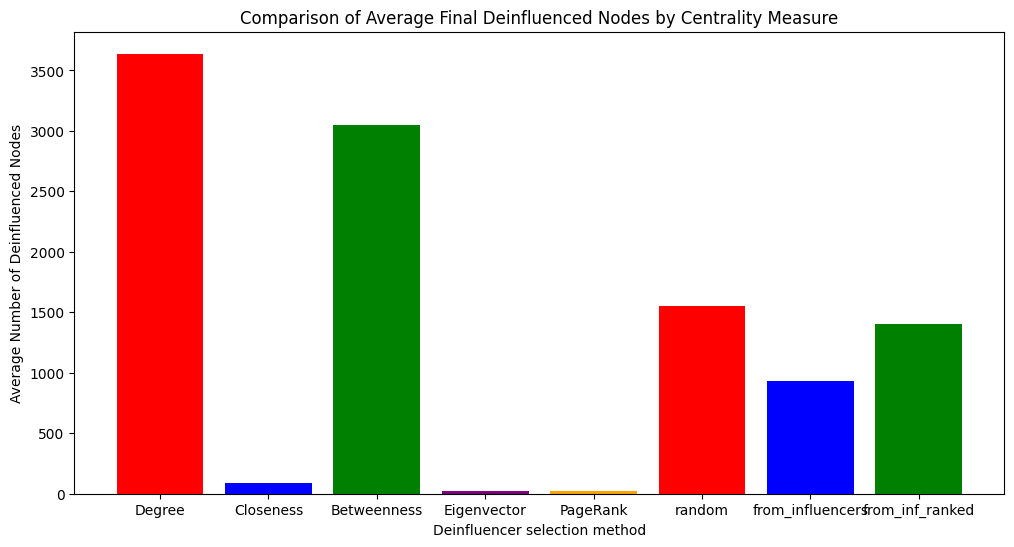

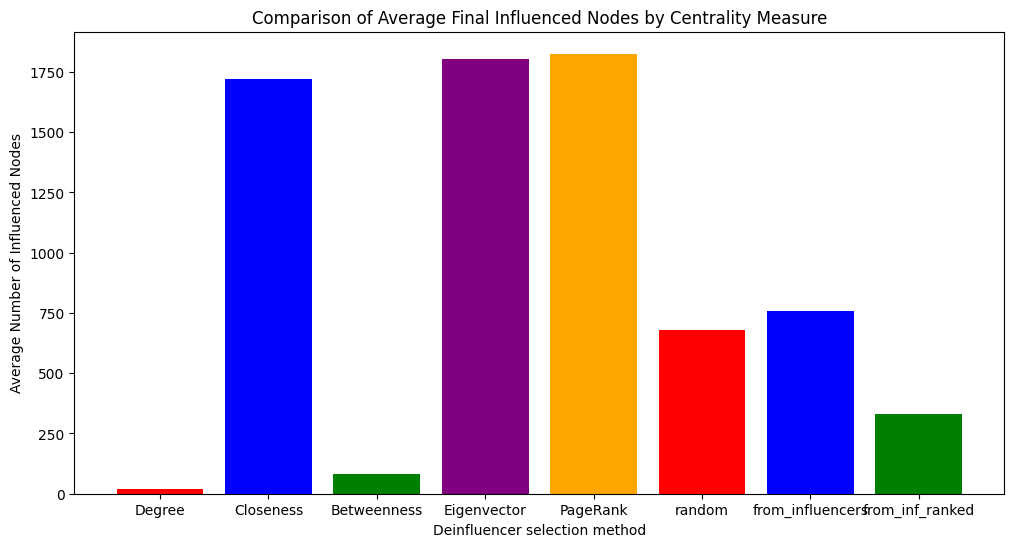

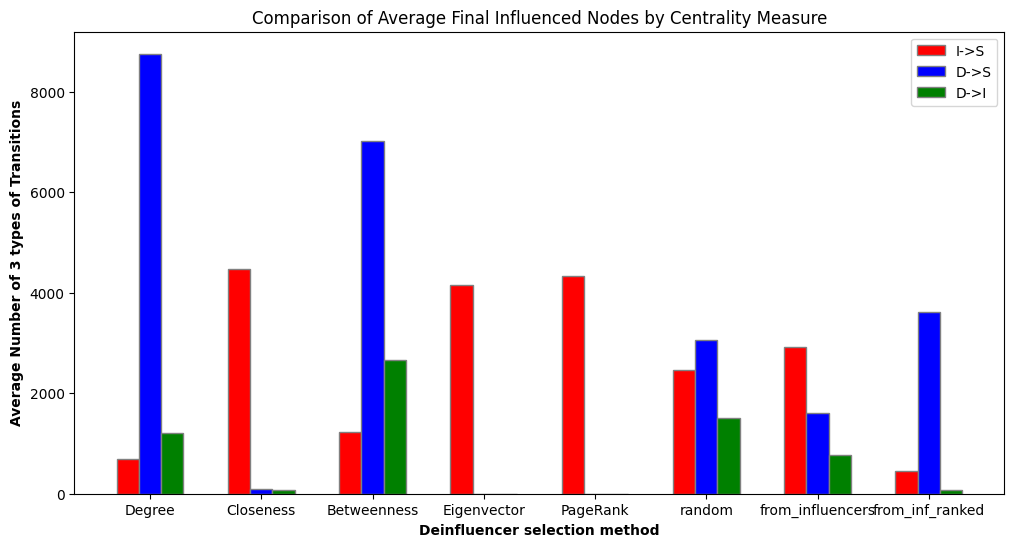

In [18]:
# Initialize the model
model.reset_graph()

# Rank nodes using different centrality measures
k_deinfluencers = 20

# Run cascades and count deinfluenced nodes for each centrality measure
num_runs = 3  # Number of times to run the cascade for averaging
steps = 3  # Number of steps to run the cascade

degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)
#optimized_deinfluencers = model.greedy_hill_climbing_deinf(k_deinfluencers, 5, 10)
deinfleucers_from_influencers = model.select_deinfluencers_from_influencers(j=k_deinfluencers)
ranked_deinfleucers_from_influencers = model.select_deinfluencers_from_influencers_degree_centrality(k_deinfluencers)


print("Degree Centrality Ranking:", degree_centrality_ranking)
print("Closeness Centrality Ranking:", closeness_centrality_ranking)
print("Betweenness Centrality Ranking:", betweenness_centrality_ranking)
print("Eigenvector Centrality Ranking:", eigenvector_centrality_ranking)
print("PageRank Centrality Ranking:", pagerank_centrality_ranking)
print("Random Deinfluencers:", random_deinfluencers)
#print("Optimized Deinfluencers:", optimized_deinfluencers)
print("Deinfluencers from Influencers:", deinfleucers_from_influencers)
print("Ranked Deinfluencers from Influencers:", ranked_deinfleucers_from_influencers)


results_d = {
    'Degree': count_deinfluenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_deinfluenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_deinfluenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_deinfluenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_deinfluenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_deinfluenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_deinfluenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_deinfluenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_deinfluenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_i = { 
    'Degree': count_influenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_influenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_influenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_influenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_influenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_influenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_influenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_influenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_influenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_w = {
    'Degree': count_transistion(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_transistion(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_transistion(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_transistion(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_transistion(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_transistion(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_transistion(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_transistion(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_transistion(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}



# Print the results
#for centrality, count in results.items():
    #print(f"{centrality}: {count:.2f} nodes deinfluenced on average")

# Plot the results
plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_d.keys(), results_d.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()


plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_i.keys(), results_i.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Influenced Nodes')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')
plt.show()

# Unpack the values
values1 = [val[0] for val in results_w.values()]
values2 = [val[1] for val in results_w.values()]
values3 = [val[2] for val in results_w.values()]

# Create a new figure
plt.figure(figsize=(12, 6))  # Increase the figure size

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(values1))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.bar(r1, values1, color='red', width=bar_width, edgecolor='grey', label='I->S')
plt.bar(r2, values2, color='blue', width=bar_width, edgecolor='grey', label='D->S')
plt.bar(r3, values3, color='green', width=bar_width, edgecolor='grey', label='D->I')

# Add labels
plt.xlabel('Deinfluencer selection method', fontweight='bold')
plt.ylabel('Average Number of 3 types of Transitions', fontweight='bold')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')

# Add the xticks
plt.xticks([r + bar_width for r in range(len(values1))], results_w.keys())

# Create legend
plt.legend()

# Show the plot
plt.show()